<center><big><b>CSE 5524 – Project

<center><big> Soccer Ball Detection

In [4]:
import skimage 
from skimage import io 
import numpy as np 
import matplotlib.pyplot as plt
import math
import cv2
import scipy.ndimage
from scipy.linalg import eigh
import matplotlib.patches as patches

### Covarience Tracking

- Load targets

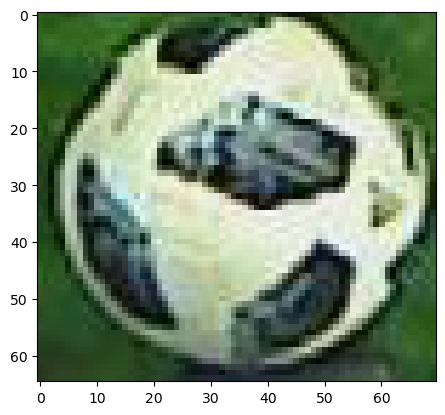

(65, 70, 3)


In [5]:
target = skimage.io.imread('target.jpg')
plt.imshow(target)
plt.show()
print(target.shape)

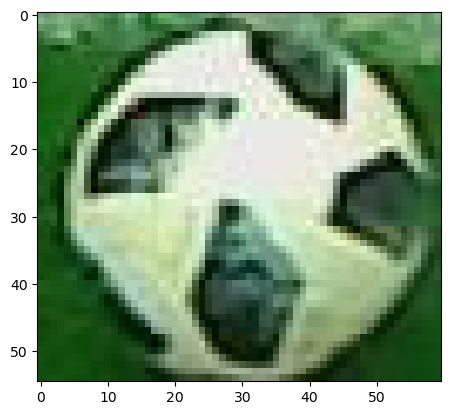

(55, 60, 3)


In [6]:
target2 = skimage.io.imread('target2.jpg')
plt.imshow(target2)
plt.show()
print(target2.shape)

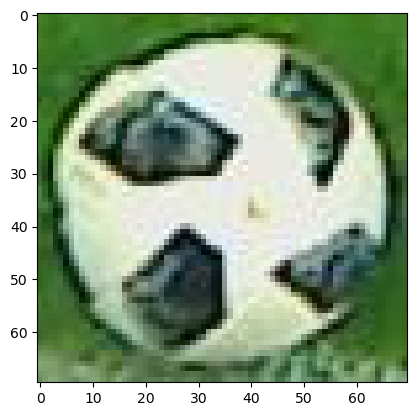

(70, 70, 3)


In [7]:
target3 = skimage.io.imread('target3.jpg')
plt.imshow(target3)
plt.show()
print(target3.shape)

In [8]:
def covarience_tracking(im, target):
    features = []

    # Build covariance matrix
    for y in range(target.shape[0]):
        for x in range(target.shape[1]):
            r, g, b = target[y, x]
            features.append([x, y, r, g, b]) 

    features_array = np.array(features)
    cov_matrix = np.cov(features_array.T) 

    model_cov = cov_matrix
    
    
    # Covariance tracking
    height, width, _ = im.shape
    window_rows, window_cols,_ = target.shape
    y, x = np.arange(window_rows).astype(np.float32), np.arange(window_cols).astype(np.float32)
    yv, xv = np.meshgrid(y, x, indexing='ij')
    yv, xv  = yv.flatten()[np.newaxis, :], xv.flatten()[np.newaxis, :]

    R, G, B = im[:, :, 0].astype(np.float32), im[:, :, 1].astype(np.float32), im[:, :, 2].astype(np.float32)

    # Calculate and save the match distance
    dists = np.zeros((height - window_rows, width - window_cols), dtype=np.float32)
    for i in range(height - window_rows):
        for j in range(width - window_cols):
            feat = np.vstack((xv, yv,
                              R[i:i+window_rows, j:j+window_cols].flatten()[np.newaxis, :],
                              G[i:i+window_rows, j:j+window_cols].flatten()[np.newaxis, :],
                              B[i:i+window_rows, j:j+window_cols].flatten()[np.newaxis, :]))
            candidate_cov = np.cov(feat, bias=True)
            eigvals = eigh(model_cov, candidate_cov, eigvals_only=True)
            dist = np.sqrt((np.log(eigvals)**2).sum())
            dists[i, j] = dist
    
    # Find the best match box
    minDiff = dists.argmin()
    minpos = minDiff // (width - window_cols), minDiff % (width - window_cols)
    return minDiff, minpos

In [9]:
def covarience_tracking_robust(im, target, target2, target3):
    
    # Select the best match beteen two targets and make it robust
    minDiff1, minpos1 = covarience_tracking(im, target)
    minDiff2, minpos2 = covarience_tracking(im, target2)
    minDiff3, minpos3 = covarience_tracking(im, target3)
    
    if minDiff1 <= minDiff2 and minDiff1 <= minDiff3:
        best_pos = minpos1
        best_target = target
    else:
        if minDiff2 <= minDiff1 and minDiff2 <= minDiff3:
            best_pos = minpos2
            best_target = target2
        else:
            best_pos = minpos3
            best_target = target3
    
    
    best_patch = im[best_pos[0]:(best_pos[0]+best_target.shape[0]),best_pos[1]:(best_pos[1]+best_target.shape[1])]
        
    return best_patch,best_target


In [10]:
def ncc_tracking(im, target):
   #Dimensions of the images
    im_height, im_width, _ = im.shape
    target_height, target_width, _ = target.shape

    #Initialize
    max_corr = -1
    max_pos = (0, 0)

    #Normalize the target
    target_mean = target.mean()
    target_std = target.std()
    target_normalized = (target - target_mean) / target_std

    for y in range(im_height - target_height + 1):
        for x in range(im_width - target_width + 1):
            # Extract sub-image
            sub_im = im[y:y + target_height, x:x + target_width]

            # Normalizing the sub-image
            sub_im_mean = sub_im.mean()
            sub_im_std = sub_im.std()
            sub_im_normalized = (sub_im - sub_im_mean) / sub_im_std

            ncc = np.sum(sub_im_normalized * target_normalized) / (target_height * target_width)

            if ncc > max_corr:
                max_corr = ncc
                
                # I think the below should be (y,x) not (x, y)?
                max_pos = (y, x)

    return ncc, max_pos

In [11]:
def ncc_tracking_robust(im, target, target2, target3):
    ncc_1, max_pos_1 = ncc_tracking(im, target)
    ncc_2, max_pos_2 = ncc_tracking(im, target2)
    ncc_3, max_pos_3 = ncc_tracking(im, target3)
    
    if ncc_1 >= ncc_2 and ncc_1 >= ncc_3:
        best_pos = max_pos_1
        best_target = target
    else:
        if ncc_2 >= ncc_1 and ncc_2 >= ncc_3:
            best_pos = max_pos_2
            best_target = target2
        else:
            best_pos = max_pos_3
            best_target = target3  
            
    
    
    # Check whether this dimension is correct
    best_patch = im[best_pos[0]:(best_pos[0]+best_target.shape[0]),best_pos[1]:(best_pos[1]+best_target.shape[1])]
        
    return best_patch,best_target
    


In [12]:
def count_near_black_and_white_pixels(im):

    image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    black_threshold = 30
    white_threshold = 225

    near_black_count = np.sum(np.all(image < black_threshold, axis=-1))

    near_white_count = np.sum(np.all(image > white_threshold, axis=-1))
    
    proportion = (near_black_count + near_white_count) / (image.shape[0] * image.shape[1])

    return proportion

In [13]:
def hybrid_covarience_ncc(im, target, target2, target3):
    best_patch, best_target = covarience_tracking_robust(im, target, target2, target3)
    best_patch2, best_target2 = ncc_tracking_robust(im, target, target2, target3)

    proportion1 = count_near_black_and_white_pixels(best_patch)
    proportion2 = count_near_black_and_white_pixels(best_patch2)
    
    if proportion1 >= proportion2:
        return best_patch
    else:
        return best_patch2
    

### Case 1

(70, 70, 3)


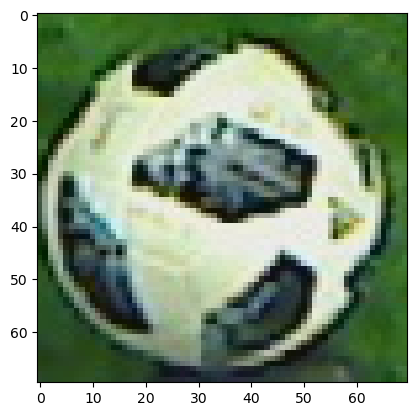

In [14]:
im = skimage.io.imread('Dataset/image0.jpg')
im2 = skimage.io.imread('Dataset/image596.jpg')
im3 = skimage.io.imread('Dataset/image794.jpg')
best_patch = hybrid_covarience_ncc(im, target, target2, target3)

print(best_patch.shape)

fig,ax = plt.subplots()
ax.imshow(best_patch)
plt.show()

### Case 2

(70, 70, 3)


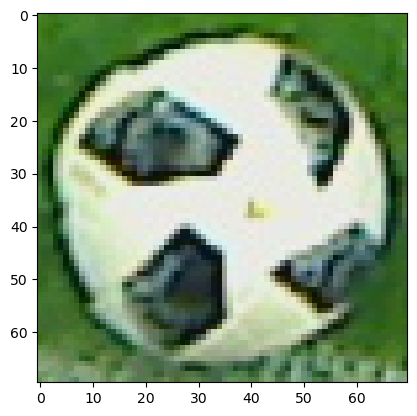

In [15]:
best_patch = hybrid_covarience_ncc(im2, target, target2, target3)

print(best_patch.shape)

fig,ax = plt.subplots()
ax.imshow(best_patch)
plt.show()

### Case 3

(55, 60, 3)


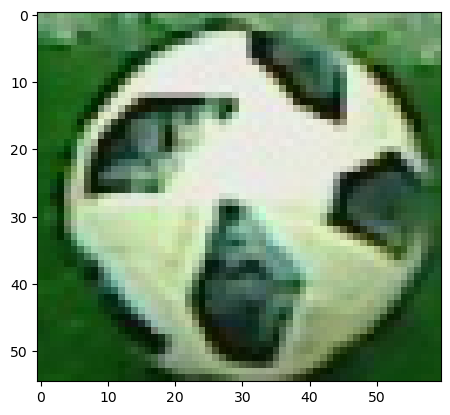

In [16]:
best_patch = hybrid_covarience_ncc(im3, target, target2, target3)

print(best_patch.shape)

fig,ax = plt.subplots()
ax.imshow(best_patch)
plt.show()

In [18]:
def testResults(target1, target2, target3):
    # 100 random numbers between the range of 0 and 1277
    random_numbers = np.random.randint(0, 1278, size=100)

    images = []
    for i in random_numbers:
        img = skimage.io.imread(f'./Dataset/image{i}.jpg')
        best_patch = hybrid_covarience_ncc(img, target1, target2, target3)
        print(f"image{i}: {best_patch.shape}")

        images.append(best_patch)

    rows = 10
    cols = 10
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')

    plt.show()

# testResults(target, target2, target3)

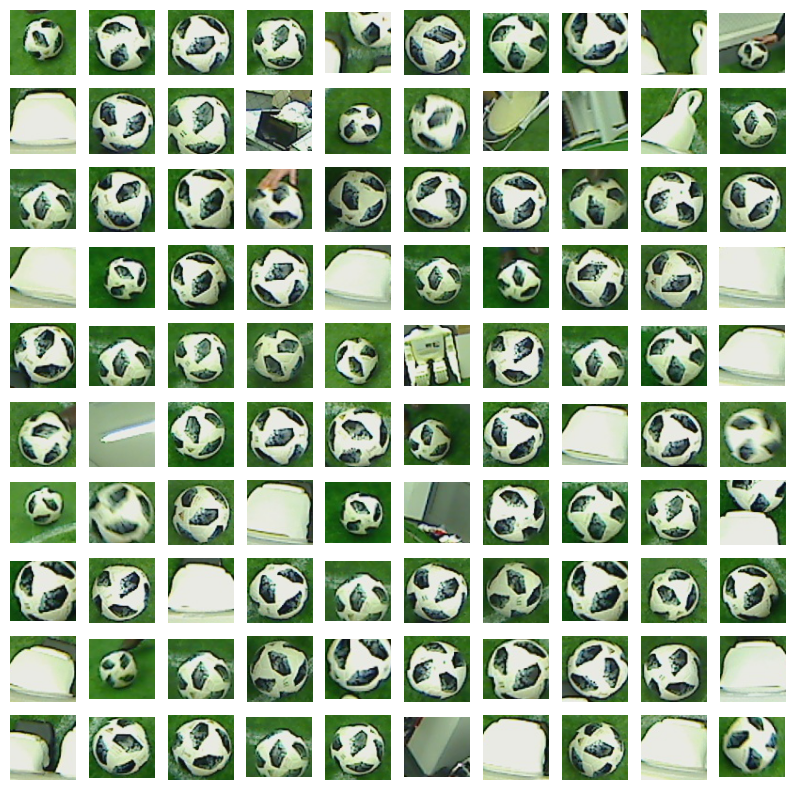